## Exploratory Data Analysis (EDA)

### Analisis Inicial

En esta sección, vamos a explorar la información básica de nuestro conjunto de datos para tener una visión general de su estructura y características. Comenzaremos cargando el archivo y verificando algunas estadísticas clave, como las primeras filas, el tipo de datos y los valores únicos de algunas columnas relevantes.

In [61]:
import pandas as pd

df = pd.read_csv("raw_data.csv", sep=";")

import warnings
warnings.filterwarnings("ignore")

In [62]:
print(df.head())
print(df.info())
print(df.describe())
print(f"Las clases unicas de: {df["metodoObtencion"].unique()}")
print(f"Las clases unicas de: {df["energiaVertida_kWh"].unique()}")


           cups       fecha   hora consumo_kWh metodoObtencion  \
0  0114f2a9ef8e  2021/08/11  01:00       0,449             NaN   
1  0114f2a9ef8e  2021/08/11  02:00       0,423             NaN   
2  0114f2a9ef8e  2021/08/11  03:00       0,411             NaN   
3  0114f2a9ef8e  2021/08/11  04:00       0,282             NaN   
4  0114f2a9ef8e  2021/08/11  05:00       0,255             NaN   

  energiaVertida_kWh  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100969 entries, 0 to 2100968
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   cups                object
 1   fecha               object
 2   hora                object
 3   consumo_kWh         object
 4   metodoObtencion     object
 5   energiaVertida_kWh  object
dtypes: object(6)
memory usage: 96.2+ MB
None
                cups       fecha     hora consumo_k

### Limpieza y preprocesamiento de datos

Una vez que hemos explorado el dataset, procederemos a realizar algunas tareas de limpieza. Primero, eliminaremos  la columna metodoObtencion y la columna energiaVertida_kWh, ya que no será relevante para el análisis de la serie temporal

In [63]:
df.drop(columns=['metodoObtencion'], inplace=True)
df.drop(columns=['energiaVertida_kWh'], inplace=True)
print(df.head())

           cups       fecha   hora consumo_kWh
0  0114f2a9ef8e  2021/08/11  01:00       0,449
1  0114f2a9ef8e  2021/08/11  02:00       0,423
2  0114f2a9ef8e  2021/08/11  03:00       0,411
3  0114f2a9ef8e  2021/08/11  04:00       0,282
4  0114f2a9ef8e  2021/08/11  05:00       0,255


Voy a preprocesar todas las columnas que quiero del dataset para que todas sigan un formato específico. Convertiré las columnas de fecha a a otra string pero con el mismo formato (formato dd/mm/yyyy). Transformare las columans de consumo_KWh y hora a float e int respectivamente para facilitar el trabajo con los datos.

In [64]:
def formatear_hora(hora):
    hora = str(hora).strip()
    
    # Convertir '1:00' a '01:00', etc.
    if len(hora.split(':')[0]) == 1:
        hora = '0' + hora
    
    # Eliminar '24:00:00' y '24:00' a '00:00' (formato más internacional)
    if hora == '24:00:00' or hora == '24:00':
        hora = '00:00'
    
    return hora

def limpiar_consumo(consumo):
    try:
        consumo = str(consumo).replace(',', '.')
        return float(consumo)
    except ValueError:
        print("HUBO ERROR")
        return float('nan')



df['fecha'] = pd.to_datetime(df['fecha'], format='mixed', dayfirst=True, errors='coerce').dt.strftime('%d/%m/%Y')
df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df['consumo_kWh'] = df['consumo_kWh'].apply(limpiar_consumo)
df['hora'] = df['hora'].apply(formatear_hora)
df['hora'] = pd.to_datetime(df['hora'], format='%H:%M', errors='coerce').dt.hour

print(df.dtypes)
print(df.head())


cups                   object
fecha          datetime64[ns]
hora                    int32
consumo_kWh           float64
dtype: object
           cups      fecha  hora  consumo_kWh
0  0114f2a9ef8e 2021-08-11     1        0.449
1  0114f2a9ef8e 2021-08-11     2        0.423
2  0114f2a9ef8e 2021-08-11     3        0.411
3  0114f2a9ef8e 2021-08-11     4        0.282
4  0114f2a9ef8e 2021-08-11     5        0.255


In [65]:
nan_check = df.isna().sum()

print("Número de valores NaN en cada columna:")
print(nan_check)
df.to_csv('mid_data.csv', sep=';', index=False)

Número de valores NaN en cada columna:
cups           0
fecha          0
hora           0
consumo_kWh    0
dtype: int64


## Transformación de datos

Voy a filtrar y formatear los datos para garantizar que todos las viviendas tengan registros consistentes desde la misma fecha inicial y desde la misma fecha final, convirtiendo las horas a formato de dos dígitos ("01" en vez de "1") y combinando fecha y hora en un solo campo ("2021-08-30 01") para poder organizar correctamente los consumos horarios en una tabla pivotada donde cada hora sea una columna y cada cliente una fila, lo que me permitirá analizar y comparar los patrones de consumo de manera uniforme. Esto soluciona el problema de que algunos clientes tenían datos incompletos en fechas anteriores y asegura que el análisis temporal sea preciso y comparable entre todos.

In [76]:
import pandas as pd

def encontrar_intervalo_comun(df):

    # Convertir la columna 'fecha' a tipo datetime si no lo está
    df['fecha'] = pd.to_datetime(df['fecha'], dayfirst=True)

    # Agrupar por 'cups' y calcular la fecha mínima y máxima para cada uno
    resumen = df.groupby('cups')['fecha'].agg(['min', 'max']).reset_index()

    # Determinar la fecha de inicio más tardía y la fecha de finalización más temprana
    fecha_inicio_comun = resumen['min'].max()
    fecha_fin_comun = resumen['max'].min()

    # Identificar los CUPS correspondientes a estas fechas
    cups_inicio = resumen.loc[resumen['min'] == fecha_inicio_comun, 'cups'].values
    cups_fin = resumen.loc[resumen['max'] == fecha_fin_comun, 'cups'].values

    return fecha_inicio_comun, fecha_fin_comun, cups_inicio, cups_fin

# Ejemplo de uso:
# df = pd.read_csv('datos_consumo.csv', sep=';')  # Cargar el DataFrame desde un archivo CSV
fecha_inicio, fecha_fin, cups_inicio, cups_fin = encontrar_intervalo_comun(df)
print(f"Fecha de inicio común: {fecha_inicio}")
print(f"Fecha de fin común: {fecha_fin}")
print(f"CUPS con fecha de inicio común: {cups_inicio}")
print(f"CUPS con fecha de fin común: {cups_fin}")

df_filtrado = df[(df['fecha'] >= fecha_inicio) & (df['fecha'] <= fecha_fin)].copy()
df_filtrado['hora_str'] = df_filtrado['hora'].astype(str).str.zfill(2)
df_filtrado['fecha_hora_str'] = df_filtrado['fecha'].dt.strftime('%Y-%m-%d') + ' ' + df_filtrado['hora_str']


Fecha de inicio común: 2023-04-30 00:00:00
Fecha de fin común: 2023-08-02 00:00:00
CUPS con fecha de inicio común: ['ceaddbf817fc']
CUPS con fecha de fin común: ['c1244d6dea7a']


​Para analizar y agrupar datos de consumo eléctrico por vivienda y momento específico, es esencial transformar el conjunto de datos de un formato largo a un formato ancho. En el formato largo, cada fila representa una medición individual con columnas como 'cups', 'fecha', 'hora' y 'consumo_kWh'. Al pivotar estos datos al formato ancho, cada fila corresponderá a una vivienda única ('cups'), y las columnas representarán combinaciones específicas de fecha y hora, mostrando el consumo en cada celda. Este formato facilita la aplicación de algoritmos de clustering y análisis comparativos entre diferentes viviendas en momentos determinados.

In [77]:
# Pivotar (solo incluirá fechas >= 2021-08-30)
df_ancho = df_filtrado.pivot_table(
    index='cups', 
    columns='fecha_hora_str',
    values='consumo_kWh',
)

# Verificar que todas las fechas empiezan desde 2021-08-30
print("Primera fecha en datos pivotados:", df_filtrado['fecha'].min())
print("Ultima fecha en datos pivotados:", df_filtrado['fecha'].max())
# Guardar
df_ancho.to_csv('end_data_filtrado.csv', sep=';', index=False)
print(df_ancho.head())

Primera fecha en datos pivotados: 2023-04-30 00:00:00
Ultima fecha en datos pivotados: 2023-08-02 00:00:00
fecha_hora_str  2023-04-30 00  2023-04-30 01  2023-04-30 02  2023-04-30 03  \
cups                                                                         
0114f2a9ef8e            0.562          0.669          0.361          0.369   
011952cf0a27            0.426          0.525          0.456          0.357   
02b3106d73c7            0.060          0.068          0.068          0.070   
03c8338d7f1d            0.173          0.214          0.083          0.102   
04666163609d            0.274          0.057          0.061          0.031   

fecha_hora_str  2023-04-30 04  2023-04-30 05  2023-04-30 06  2023-04-30 07  \
cups                                                                         
0114f2a9ef8e            0.332          0.349          0.345          0.312   
011952cf0a27            0.396          0.280          0.092          0.088   
02b3106d73c7            0.067     

In [78]:
# 3. Análisis de NaN (3 métodos)
print("\n🔍 Análisis de valores faltantes:")

# Método 1: Conteo total de NaN
total_nan = df_ancho.isna().sum().sum()
print(f"- Total de NaN en la tabla: {total_nan}")


🔍 Análisis de valores faltantes:
- Total de NaN en la tabla: 2


In [79]:
import pandas as pd
import numpy as np

# Obtener posiciones de todos los NaN
nan_positions = np.where(df_ancho.isna())

# Extraer detalles de cada NaN
nan_details = []
for row, col in zip(*nan_positions):
    cups = df_ancho.index[row]  # Nombre del CUPS (fila)
    fecha_hora = df_ancho.columns[col]  # Fecha-hora (columna)
    nan_details.append({
        'CUPS': cups,
        'Fecha_Hora': fecha_hora,
        'Posicion_DataFrame': (row, col)
    })

# Convertir a DataFrame
nan_report = pd.DataFrame(nan_details)

# Mostrar el reporte completo
print("Reporte detallado de NaN:")
print(nan_report)

# Guardar como CSV
nan_report.to_csv('registros_faltantes.csv', index=False)

Reporte detallado de NaN:
           CUPS     Fecha_Hora Posicion_DataFrame
0  6fadd3d6b297  2023-07-28 05         (60, 2141)
1  ad7b0d773a4a  2023-07-30 06         (90, 2190)


In [70]:
print(df_ancho.head(1))  # Mira la primera fila para confirmar
# Obtener el nombre del CUPS en la fila 19 (índice del pivot)
cups_fila_19 = df_ancho.index[19]
print(f"El CUPS en la fila 19 del pivot es: {cups_fila_19}")

fecha_hora_str  2021-08-30 00  2021-08-30 01  2021-08-30 02  2021-08-30 03  \
cups                                                                         
0114f2a9ef8e            0.388          0.492           0.44          0.424   

fecha_hora_str  2021-08-30 04  2021-08-30 05  2021-08-30 06  2021-08-30 07  \
cups                                                                         
0114f2a9ef8e            0.411          0.347          0.258          0.338   

fecha_hora_str  2021-08-30 08  2021-08-30 09  ...  2023-08-01 14  \
cups                                          ...                  
0114f2a9ef8e            0.393          0.277  ...          0.455   

fecha_hora_str  2023-08-01 15  2023-08-01 16  2023-08-01 17  2023-08-01 18  \
cups                                                                         
0114f2a9ef8e            1.102          0.632          0.584          0.566   

fecha_hora_str  2023-08-01 19  2023-08-01 20  2023-08-01 21  2023-08-01 22  \
cups        

### Visualización de las distribuciones de consumo eléctrico

A continuación, realizaremos un análisis de la serie temporal para viviendas al azar. Esto nos permitirá observar cómo se distribuye el consumo eléctrico a lo largo del tiempo y detectar posibles patrones, tendencias o picos en su comportamiento. Utilizaremos Matplotlib para visualizar los datos y obtener una mejor comprensión de la evolución del consumo eléctrico de la vivienda.


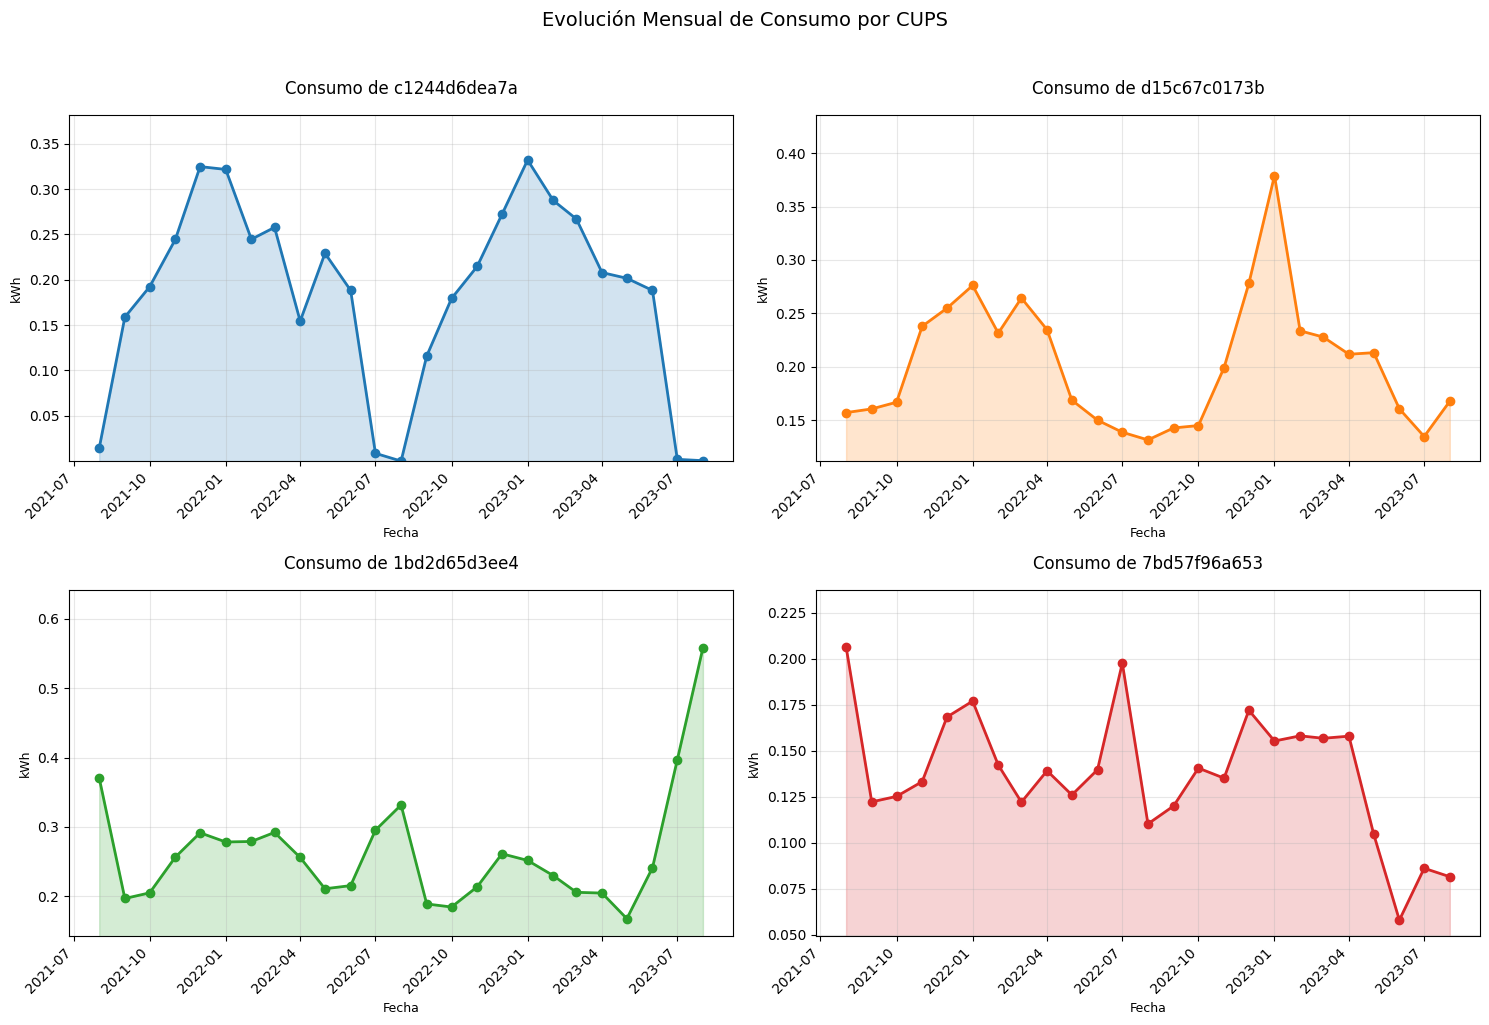

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Lista de CUPS
cups_lista = [
    "c1244d6dea7a",
    "d15c67c0173b",
    "1bd2d65d3ee4",
    "7bd57f96a653"
]


df_filtrado = df[df["cups"].isin(cups_lista)].copy()
df_filtrado["año_mes"] = df_filtrado["fecha"].dt.to_period("M").astype(str)
df_agrupado = df_filtrado.groupby(["cups", "año_mes"])["consumo_kWh"].mean().reset_index()
df_agrupado["fecha_graf"] = pd.to_datetime(df_agrupado["año_mes"] + "-01")


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
colores = cm.tab10.colors

# Graficar cada CUPS en su subgráfica
for (cups, ax), color in zip(zip(cups_lista, axes.flat), colores):

    df_cups = df_agrupado[df_agrupado["cups"] == cups].sort_values("fecha_graf")

    ax.plot(df_cups["fecha_graf"], 
            df_cups["consumo_kWh"], 
            color=color,
            linewidth=2,
            marker="o")
    
    ax.fill_between(df_cups["fecha_graf"],
                   df_cups["consumo_kWh"],
                   color=color,
                   alpha=0.2)
    
    ax.set_title(f"Consumo de {cups}", fontsize=12, pad=15)
    ax.set_xlabel("Fecha", fontsize=9)
    ax.set_ylabel("kWh", fontsize=9)
    ax.grid(True, alpha=0.3)
    
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    
    ymin = df_cups["consumo_kWh"].min() * 0.85
    ymax = df_cups["consumo_kWh"].max() * 1.15
    ax.set_ylim(ymin, ymax)

plt.suptitle("Evolución Mensual de Consumo por CUPS", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

Si tienes más variables que afectan el consumo eléctrico (como el método de obtención de energía o la energía vertida), es importante explorar cómo se relacionan entre sí.

Puedes utilizar un heatmap de correlación para ver relaciones entre variables:

In [ ]:
import seaborn as sns

# Seleccionar variables numéricas (ejemplo)
variables = ['consumo_mensual', 'variabilidad', 'dias_activos', 'hora_pico']

# Calcular y graficar
plt.figure(figsize=(10, 6))
sns.heatmap(df_mensual[variables].corr(), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1)
plt.title('Matriz de correlación entre variables clave')
plt.show()

ValueError: could not convert string to float: '0114f2a9ef8e'

Verifica si hay valores atípicos en el consumo eléctrico que podrían afectar el clustering.

In [ ]:
sns.boxplot(df['consumo_kWh'])
plt.title('Detección de Outliers en Consumo Eléctrico')
plt.show()


Si tienes varias viviendas (diferentes CUPS), puede ser útil realizar un análisis de agrupamiento por vivienda para ver si hay patrones de consumo comunes entre viviendas similares. Esto te ayudará más adelante en el proceso de clustering.

Puedes analizar si existen patrones estacionales o de consumo diario.

In [ ]:
df.groupby('cups')['consumo_kWh'].mean().sort_values(ascending=False).head()
